<a href="https://colab.research.google.com/github/KaustubhRatna/Deep-Learning-Projects/blob/main/aptos_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and Modelling

# Imports

In [ ]:
import numpy as np 
import pandas as pd
import cv2
import os
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,DenseNet121,ResNet50,InceptionV3,EfficientNetB3
import tensorflow_addons as tfa
from tensorflow.keras import layers
import tensorflow as tf
from tqdm import notebook
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 64

# Reading the data

In [ ]:
df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


## Train Test Split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df['id_code'], df['diagnosis'], test_size=0.15, stratify=df['diagnosis'],random_state=100)
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
x_train.head()

0    a8582e346df0
1    57db4781e7ec
2    50d8a8fb7737
3    e03e70bc8bba
4    1b32e1d775ea
Name: id_code, dtype: object

In [ ]:
y_train

0       1
1       0
2       2
3       2
4       4
       ..
3107    1
3108    0
3109    2
3110    0
3111    0
Name: diagnosis, Length: 3112, dtype: int64

# Preprocessing

## Adding complete path

In [ ]:
x_train = x_train.apply(lambda i:'/kaggle/input/aptos2019-blindness-detection/train_images/' + i + ".png")
x_val = x_val.apply(lambda i: '/kaggle/input/aptos2019-blindness-detection/train_images/' + i + ".png")

## Cropping the image

### Method 1 (Looses some info)

In [ ]:
path = "/kaggle/input/aptos2019-blindness-detection/train_images/001639a390f0.png"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def crop_image(img):
    
    #Determine height and width
    h = img.shape[0]
    w = img.shape[1]

    #Determine centre pixel
    Ch = h//2
    Cw = w//2

    #Determine the first non-black pixel directly abovethe center pixel at the top
    P = 0
    for i in range(Ch):
        if not(all(img[i][Cw] == 0)):
            P = i
            break;

    #Determine the radius of the retina
    R = Ch - P

    #Determine the boundaries for cropping
    X1 = (Ch-R)
    X2 = (Ch+R)
    Y1 = (Cw-R)
    Y2 = (Cw+R)

    img_cropped = []
    #Crop the image
    for i in range(3):
        img_cropped.append(img[X1:X2,Y1:Y2,i])

    img_cropped = np.dstack(img_cropped)
    return img_cropped

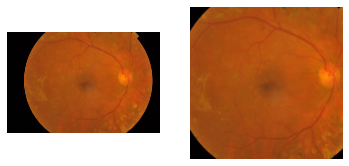

In [ ]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img);
plt.subplot(1, 2, 2)
plt.axis('off')
img_cropped= crop_image(img)
plt.imshow(img_cropped);

### Method 2 (Better)

In [ ]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # For Grayscale images
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis = 1),mask.any(axis = 0))] # mask.any(axis = 1) makes a boolean array where each element in the array corresponds to each row in the image matrix. For a given row, the corresponding boolean value in the array is true if any value in the row is true.
                                                                  # mask.any(axis = 0) makes a boolean array where each element in the array corresponds to each col in the image matrix. For a given col, the corresponding boolean value in the array is true if any value in the col is true.
                                                                  # np.ix_(mask.any(axis = 1),mask.any(axis = 0)) gets those pixels from the image for which both the row and the column value is true.
    
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #RGB image to grayscale
        mask = gray_img > tol #creates a boolean matrix
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # Whole image is cropped as it was too dark,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(axis = 1),mask.any(axis = 0))] #applies mask to pixel 0
            img2=img[:,:,1][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img3=img[:,:,2][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

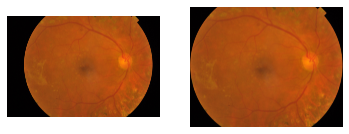

In [ ]:
path = "/kaggle/input/aptos2019-blindness-detection/train_images/001639a390f0.png"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img);
plt.subplot(1, 2, 2)
img_cropped = crop_image_from_gray(img)
plt.axis('off')
plt.imshow(img_cropped);

## Preprocessing pipeline
https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

In [ ]:
def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted (image, 4, cv2.GaussianBlur(image, (0,0) ,10), -4, 128)
    return image

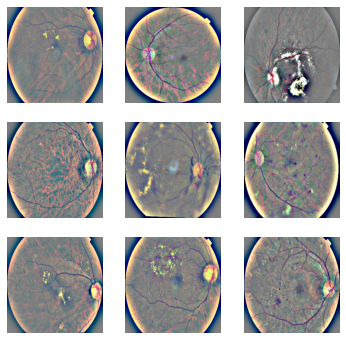

In [ ]:
plt.figure(figsize=(6,6))
for y,x in enumerate(x_train[:9]):
    plt.subplot(3, 3, y+1)
    plt.axis('off')
    i = preprocess(x)
    plt.imshow(i)

# Model Training

## Making an array of train and validation images

In [ ]:
train_images = np.empty((len(x_train),IMG_SIZE,IMG_SIZE,3), dtype='uint8')
for i,path in enumerate(notebook.tqdm(x_train)):
    train_images[i] = preprocess(path)

  0%|          | 0/3112 [00:00<?, ?it/s]

In [ ]:
y_train = pd.get_dummies(y_train).values

In [ ]:
val_images = np.empty((len(x_val),IMG_SIZE,IMG_SIZE,3), dtype='uint8')
for i,path in enumerate(notebook.tqdm(x_val)):
    val_images[i] = preprocess(path)

  0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
y_val = pd.get_dummies(y_val).values

## Metric

In [ ]:
qwk = tfa.metrics.CohenKappa(5,weightage='quadratic')

## Simple CNN

In [ ]:
import numpy as np 
import pandas as pd 
import cv2
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [ ]:
model1=Sequential()
model1.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(256,256,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(5,activation="softmax"))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)      

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)      

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[qwk]
              )

In [ ]:
history = model1.fit(train_images, y_train, 
                     steps_per_epoch= len(y_train) // BATCH_SIZE, 
                     epochs=100, 
                     validation_data = (val_images,y_val), 
                     validation_steps = len(y_val) // BATCH_SIZE,
                     )

Epoch 1/100
48/48 [==============================] - 4s 57ms/step - loss: 91.1682 - cohen_kappa: 0.4265 - val_loss: 0.8201 - val_cohen_kappa: 0.6380
Epoch 2/100
48/48 [==============================] - 2s 47ms/step - loss: 0.8158 - cohen_kappa: 0.6305 - val_loss: 0.7419 - val_cohen_kappa: 0.6721
Epoch 3/100
48/48 [==============================] - 2s 48ms/step - loss: 0.7322 - cohen_kappa: 0.6798 - val_loss: 0.7198 - val_cohen_kappa: 0.6774
Epoch 4/100
48/48 [==============================] - 2s 47ms/step - loss: 0.6696 - cohen_kappa: 0.7079 - val_loss: 0.6950 - val_cohen_kappa: 0.6925
Epoch 5/100
48/48 [==============================] - 2s 47ms/step - loss: 0.6336 - cohen_kappa: 0.7226 - val_loss: 0.6966 - val_cohen_kappa: 0.7315
Epoch 6/100
48/48 [==============================] - 2s 49ms/step - loss: 0.5723 - cohen_kappa: 0.7755 - val_loss: 0.6969 - val_cohen_kappa: 0.7075
Epoch 7/100
48/48 [==============================] - 2s 49ms/step - loss: 0.5271 - cohen_kappa: 0.8049 - val_lo

### Plots

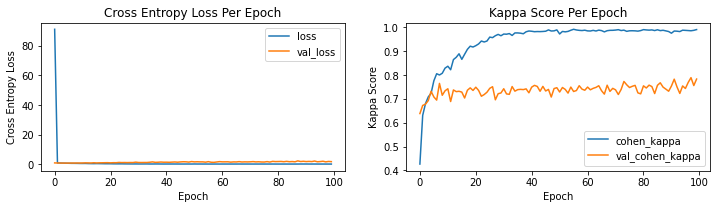

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

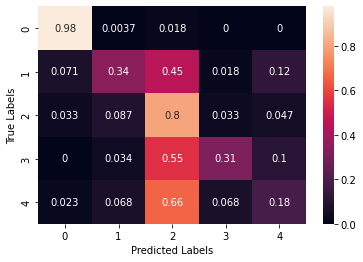

In [ ]:
from sklearn.preprocessing import normalize
y_pred = model1.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
normed_confusion_matrix = normalize(cf_matrix , axis = 1, norm = 'l1')
cm_df = pd.DataFrame(normed_confusion_matrix)
sns.heatmap (cm_df , annot =True)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)),2)
print(score)

0.77


In [ ]:
report = classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       271
           1       0.51      0.34      0.41        56
           2       0.62      0.80      0.70       150
           3       0.50      0.31      0.38        29
           4       0.32      0.18      0.23        44

    accuracy                           0.77       550
   macro avg       0.58      0.52      0.54       550
weighted avg       0.75      0.77      0.75       550



In [ ]:
model1.save("CNN.h5")

# Transfer Learning

## VGG 16

In [ ]:
vgg16_model=VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
x = vgg16_model.output
x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
vgg16_output = layers.Dense(units=5, activation='softmax')(x)


In [ ]:
model_vgg = tf.keras.Model(inputs = vgg16_model.inputs, outputs=vgg16_output)

In [ ]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[qwk]
              )

In [ ]:
history_vgg = model_vgg.fit(train_images, y_train, 
                            steps_per_epoch= len(y_train) // BATCH_SIZE, 
                            epochs=100,
                            validation_data = (val_images,y_val), 
                            validation_steps = len(y_val) // BATCH_SIZE
                           )

Epoch 1/100
48/48 [==============================] - 60s 932ms/step - loss: 7.4944 - cohen_kappa: 0.1024 - val_loss: 0.9743 - val_cohen_kappa: 0.6156
Epoch 2/100
48/48 [==============================] - 26s 550ms/step - loss: 1.0062 - cohen_kappa: 0.5389 - val_loss: 0.8916 - val_cohen_kappa: 0.6699
Epoch 3/100
48/48 [==============================] - 26s 550ms/step - loss: 0.9686 - cohen_kappa: 0.5985 - val_loss: 0.8949 - val_cohen_kappa: 0.6547
Epoch 4/100
48/48 [==============================] - 26s 550ms/step - loss: 0.9344 - cohen_kappa: 0.5969 - val_loss: 0.8419 - val_cohen_kappa: 0.6902
Epoch 5/100
48/48 [==============================] - 26s 550ms/step - loss: 0.8954 - cohen_kappa: 0.6116 - val_loss: 0.8668 - val_cohen_kappa: 0.6697
Epoch 6/100
48/48 [==============================] - 26s 550ms/step - loss: 0.8884 - cohen_kappa: 0.6207 - val_loss: 0.8029 - val_cohen_kappa: 0.7126
Epoch 7/100
48/48 [==============================] - 26s 550ms/step - loss: 0.8832 - cohen_kappa: 0.

### Plots

In [ ]:
model_vgg.save("vgg.h5")

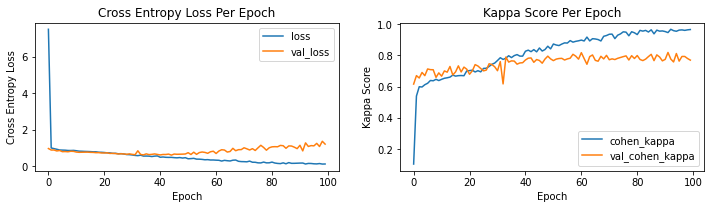

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_vgg.history['loss'],label='loss')
plt.plot(history_vgg.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_vgg.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_vgg.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

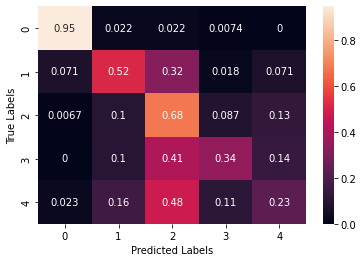

In [ ]:
from sklearn.preprocessing import normalize
y_pred = model_vgg.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
normed_confusion_matrix = normalize(cf_matrix , axis = 1, norm = 'l1')
cm_df = pd.DataFrame(normed_confusion_matrix)
sns.heatmap (cm_df , annot =True)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)),2)
print(score)

0.74


In [ ]:
report = classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       271
           1       0.48      0.52      0.50        56
           2       0.64      0.68      0.66       150
           3       0.32      0.34      0.33        29
           4       0.27      0.23      0.25        44

    accuracy                           0.74       550
   macro avg       0.54      0.54      0.54       550
weighted avg       0.74      0.74      0.74       550



## ResNet50

In [ ]:
# cb = Save_CB('Resnet')

In [ ]:
resnet = ResNet50(weights='imagenet', 
                  include_top=False, 
                  input_shape=(IMG_SIZE,IMG_SIZE,3)
                 )

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
resnet_op = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_rn = tf.keras.Model(inputs = resnet.inputs, outputs=resnet_op)

In [ ]:
model_rn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model_rn.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[qwk]
              )

In [ ]:
history_rn = model_rn.fit(train_images, y_train, 
                            steps_per_epoch= len(y_train) // BATCH_SIZE, 
                            epochs=100,
                            validation_data = (val_images,y_val), 
                            validation_steps = len(y_val) // BATCH_SIZE,
                           )

Epoch 1/100
48/48 [==============================] - 23s 475ms/step - loss: 0.7663 - cohen_kappa: 0.7599 - val_loss: 4915.7769 - val_cohen_kappa: 0.0000e+00
Epoch 2/100
48/48 [==============================] - 20s 410ms/step - loss: 0.5014 - cohen_kappa: 0.8616 - val_loss: 309.6094 - val_cohen_kappa: 0.0801
Epoch 3/100
48/48 [==============================] - 20s 411ms/step - loss: 0.4494 - cohen_kappa: 0.8873 - val_loss: 10930.7861 - val_cohen_kappa: 0.0046
Epoch 4/100
48/48 [==============================] - 20s 411ms/step - loss: 0.4592 - cohen_kappa: 0.8784 - val_loss: 115.3374 - val_cohen_kappa: 0.0000e+00
Epoch 5/100
48/48 [==============================] - 20s 410ms/step - loss: 0.3876 - cohen_kappa: 0.8966 - val_loss: 1.7516 - val_cohen_kappa: 0.5739
Epoch 6/100
48/48 [==============================] - 20s 410ms/step - loss: 0.2783 - cohen_kappa: 0.9333 - val_loss: 1.8488 - val_cohen_kappa: 0.6642
Epoch 7/100
48/48 [==============================] - 20s 411ms/step - loss: 0.225

In [ ]:
model_rn.save("resnet50.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Plots

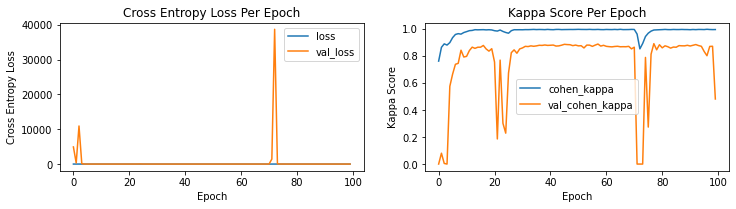

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_rn.history['loss'],label='loss')
plt.plot(history_rn.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_rn.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_rn.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

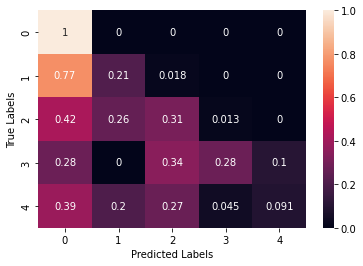

In [ ]:
from sklearn.preprocessing import normalize
y_pred = model_rn.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
normed_confusion_matrix = normalize(cf_matrix , axis = 1, norm = 'l1')
cm_df = pd.DataFrame(normed_confusion_matrix)
sns.heatmap (cm_df , annot =True)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)),2)
print(score)

0.62


In [ ]:
report = classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.67      1.00      0.81       271
           1       0.20      0.21      0.21        56
           2       0.67      0.31      0.42       150
           3       0.67      0.28      0.39        29
           4       0.57      0.09      0.16        44

    accuracy                           0.62       550
   macro avg       0.56      0.38      0.40       550
weighted avg       0.62      0.62      0.57       550



## InceptionNetV3

In [ ]:
incnet = InceptionV3(weights='imagenet', 
                     include_top=False, 
                     input_shape=(IMG_SIZE,IMG_SIZE,3)
                    )

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
x = incnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
incnet_op = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_in = tf.keras.Model(inputs = incnet.inputs, outputs=incnet_op)

In [ ]:
model_in.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
model_in.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              metrics=[qwk]
              )

In [ ]:
history_in = model_in.fit(train_images, y_train, 
                            steps_per_epoch= len(y_train) // BATCH_SIZE, 
                            epochs=100,
                            validation_data = (val_images,y_val), 
                            validation_steps = len(y_val) // BATCH_SIZE,
                           )

Epoch 1/100
48/48 [==============================] - 24s 377ms/step - loss: 0.2601 - cohen_kappa: 0.9348 - val_loss: 0.9645 - val_cohen_kappa: 0.7645
Epoch 2/100
48/48 [==============================] - 17s 346ms/step - loss: 0.1169 - cohen_kappa: 0.9734 - val_loss: 1.2237 - val_cohen_kappa: 0.8153
Epoch 3/100
48/48 [==============================] - 17s 345ms/step - loss: 0.0660 - cohen_kappa: 0.9832 - val_loss: 2.0302 - val_cohen_kappa: 0.7735
Epoch 4/100
48/48 [==============================] - 17s 346ms/step - loss: 0.0624 - cohen_kappa: 0.9851 - val_loss: 1.7328 - val_cohen_kappa: 0.8473
Epoch 5/100
48/48 [==============================] - 17s 346ms/step - loss: 0.0646 - cohen_kappa: 0.9843 - val_loss: 1.5235 - val_cohen_kappa: 0.7525
Epoch 6/100
48/48 [==============================] - 17s 346ms/step - loss: 0.0706 - cohen_kappa: 0.9812 - val_loss: 1.4243 - val_cohen_kappa: 0.7952
Epoch 7/100
48/48 [==============================] - 17s 344ms/step - loss: 0.0761 - cohen_kappa: 0.

### Plots

In [ ]:
model_in.save("inception.h5")

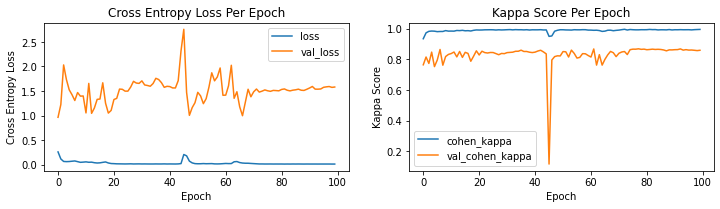

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_in.history['loss'],label='loss')
plt.plot(history_in.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_in.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_in.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

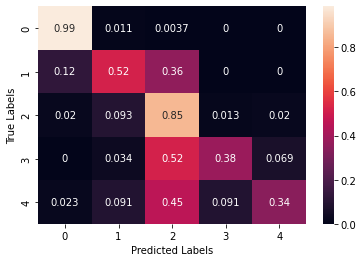

In [ ]:
from sklearn.preprocessing import normalize
y_pred = model_in.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
normed_confusion_matrix = normalize(cf_matrix , axis = 1, norm = 'l1')
cm_df = pd.DataFrame(normed_confusion_matrix)
sns.heatmap (cm_df , annot =True)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)),2)
print(score)

0.82


In [ ]:
report = classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       271
           1       0.57      0.52      0.54        56
           2       0.70      0.85      0.77       150
           3       0.65      0.38      0.48        29
           4       0.75      0.34      0.47        44

    accuracy                           0.82       550
   macro avg       0.72      0.62      0.65       550
weighted avg       0.81      0.82      0.81       550



## Summary

In [ ]:
pt = PrettyTable()

In [ ]:
pt.field_names = ['Model','Val Loss','Val Kappa']
# pt.add_row(["Baseline", min(history.history['val_loss']), max(history.history['val_cohen_kappa'])])
pt.add_row(["VGG16", min(history_vgg.history['val_loss']), max(history_vgg.history['val_cohen_kappa'])])
pt.add_row(["ResNet50", min(history_rn.history['val_loss']), max(history_rn.history['val_cohen_kappa'])])
pt.add_row(["InceptionV3", min(history_in.history['val_loss']), max(history_in.history['val_cohen_kappa'])])

In [ ]:
print(pt)

+-------------+--------------------+--------------------+
|    Model    |      Val Loss      |     Val Kappa      |
+-------------+--------------------+--------------------+
|    VGG16    | 0.6147769689559937 | 0.8184075355529785 |
|   ResNet50  | 0.7936369776725769 | 0.8888062834739685 |
| InceptionV3 | 0.9644755125045776 | 0.8690040111541748 |
+-------------+--------------------+--------------------+
